In [1]:
# import os
# if os.path.exists("best_model.pth"):
#     os.remove("best_model.pth")
# if os.path.exists("/kaggle/working/submission.csv"):
#     os.remove("/kaggle/working/submission.csv")

# Imports

In [34]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [3]:
train_df = pd.read_csv("/kaggle/input/beyond-nti-r-1-c-2/train.csv")
test_df = pd.read_csv("/kaggle/input/beyond-nti-r-1-c-2/test.csv")

# Data info

**Train**

In [4]:
print(train_df.shape)
print(train_df.dtypes.value_counts())
print(train_df.isna().sum().sum())


(4000000, 56)
int64    56
Name: count, dtype: int64
0


**Test**

In [5]:
print(test_df.shape)
print(test_df.dtypes.value_counts())
print(test_df.isna().sum().sum())


(1000000, 55)
int64    55
Name: count, dtype: int64
0


**Target**

Cover_Type
2    2262087
1    1468136
3     195712
7      62261
6      11426
4        377
5          1
Name: count, dtype: int64
Cover_Type
2    56.55 %
1     36.7 %
3     4.89 %
7     1.56 %
6     0.29 %
4     0.01 %
5      0.0 %
Name: proportion, dtype: object


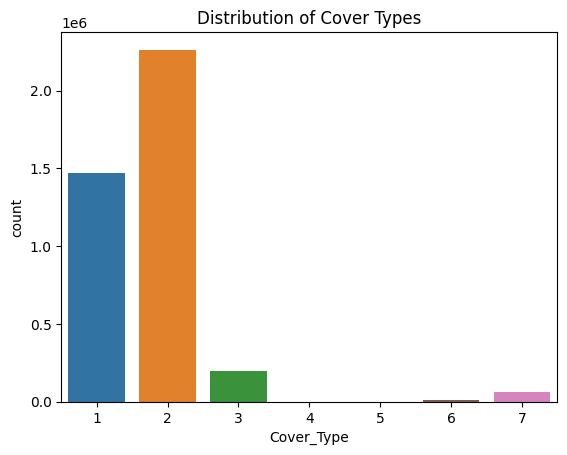

In [6]:
print(train_df['Cover_Type'].value_counts())
target_dist = train_df["Cover_Type"].value_counts(normalize=True) * 100
print(target_dist.round(2).astype(str) + " %")
sns.countplot(x="Cover_Type", data=train_df)
plt.title("Distribution of Cover Types")
plt.show()

**Skewness calculation**

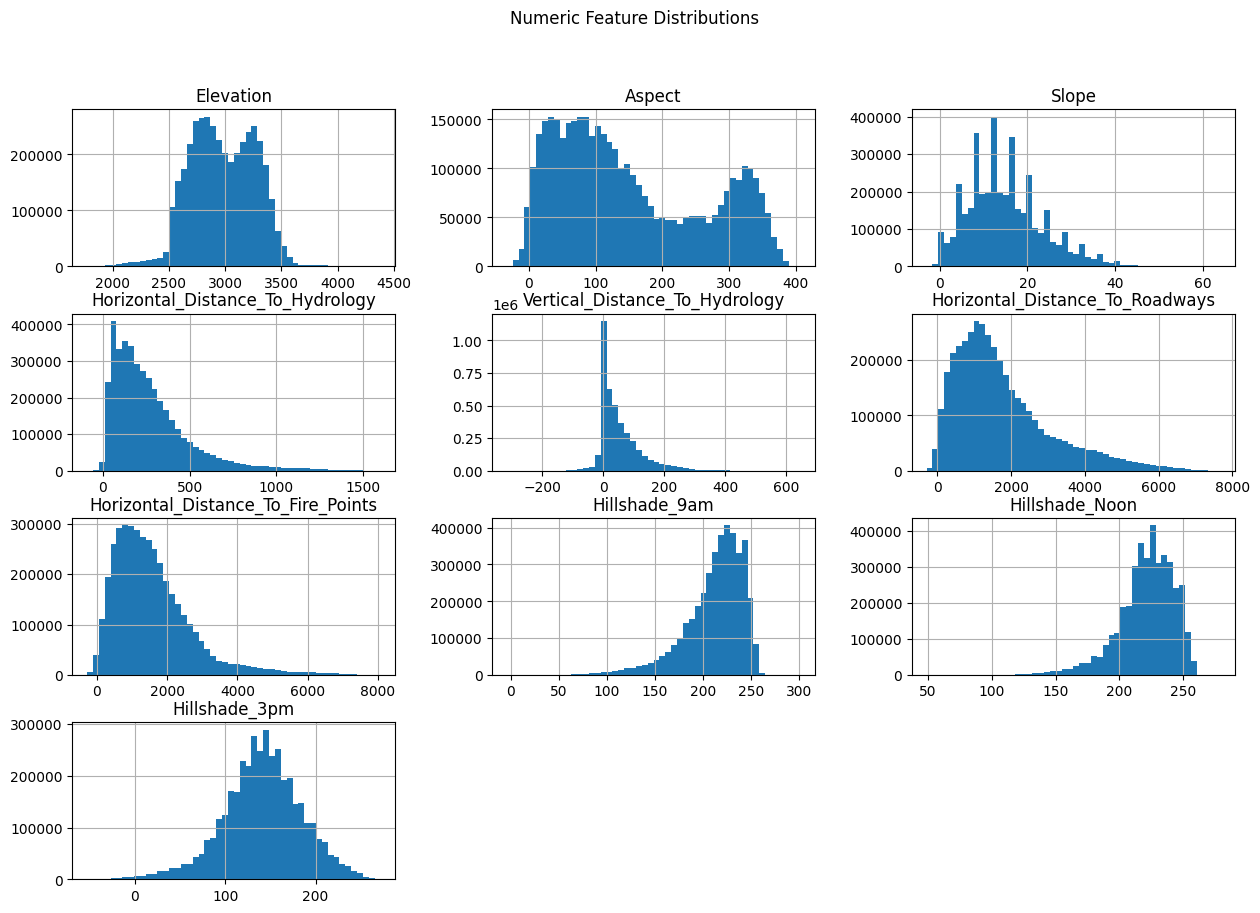

Skewness of numeric features: 
Vertical_Distance_To_Hydrology        1.755169
Horizontal_Distance_To_Hydrology      1.750869
Horizontal_Distance_To_Fire_Points    1.552941
Horizontal_Distance_To_Roadways       1.229078
Slope                                 0.732752
Aspect                                0.498374
Elevation                            -0.063051
Hillshade_3pm                        -0.316813
Hillshade_Noon                       -1.146600
Hillshade_9am                        -1.342551
dtype: float64


In [7]:
num_cols = [
    "Elevation","Aspect","Slope",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points",
    "Hillshade_9am","Hillshade_Noon","Hillshade_3pm"
]

train_df[num_cols].hist(bins=50, figsize=(15,10))
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Calculate skewness
skew_vals = train_df[num_cols].skew().sort_values(ascending=False)

print(f'Skewness of numeric features: \n{skew_vals}')

**Correlation matrix**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


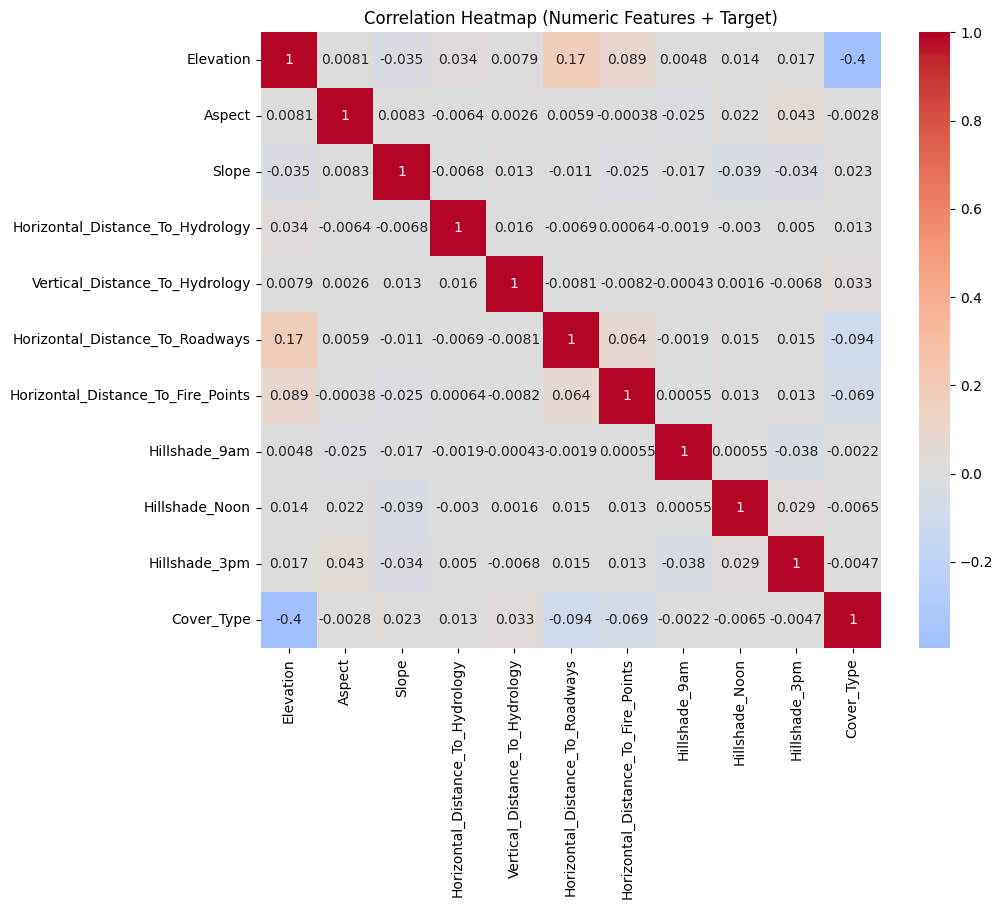

Correlation with Cover_Type:
 Cover_Type                            1.000000
Vertical_Distance_To_Hydrology        0.033007
Slope                                 0.023137
Horizontal_Distance_To_Hydrology      0.012712
Hillshade_9am                        -0.002229
Aspect                               -0.002828
Hillshade_3pm                        -0.004694
Hillshade_Noon                       -0.006536
Horizontal_Distance_To_Fire_Points   -0.069258
Horizontal_Distance_To_Roadways      -0.093850
Elevation                            -0.395961
Name: Cover_Type, dtype: float64


In [8]:
num_cols_with_target = num_cols + ["Cover_Type"]

corr = train_df[num_cols_with_target].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.show()

# Print correlation values
# print("Correlation matrix:\n", corr, "\n")

# Correlation with the target
print("Correlation with Cover_Type:\n", corr["Cover_Type"].sort_values(ascending=False))

# Features transformation

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def preprocess_data(train_df, test_df, n_soil_pca=10, n_clusters=5, shift_value=1.0,
                    clip_percentile=0.01, apply_log_ratios=True):

    train_transformed = train_df.copy()
    test_transformed  = test_df.copy()

    sqrt_cols = [
        "Slope",
        "Horizontal_Distance_To_Hydrology",
        "Horizontal_Distance_To_Roadways",
        "Horizontal_Distance_To_Fire_Points"
    ]

    # --- Base transformations ---
    for df in [train_transformed, test_transformed]:
        # sqrt for skewed cols
        for col in sqrt_cols:
            min_val = df[col].min()
            if min_val < 0:
                df[col] = np.sqrt(df[col] - min_val + shift_value)
            else:
                df[col] = np.sqrt(df[col] + shift_value)

        # Aspect → sin/cos
        df["Aspect_sin"] = np.sin(np.radians(df["Aspect"]))
        df["Aspect_cos"] = np.cos(np.radians(df["Aspect"]))
        df.drop(columns=["Aspect"], inplace=True)

        # Hydrology-based features
        df["Hydro_Dist"] = np.sqrt(
            df["Horizontal_Distance_To_Hydrology"]**2 +
            df["Vertical_Distance_To_Hydrology"]**2
        )
        df["Relative_Elevation"] = df["Elevation"] - df["Vertical_Distance_To_Hydrology"]

        # Averages
        df["Mean_Horiz_Distance"] = (
            df["Horizontal_Distance_To_Hydrology"] +
            df["Horizontal_Distance_To_Roadways"] +
            df["Horizontal_Distance_To_Fire_Points"]
        ) / 3
        df["Road_Fire_Mean"] = (
            df["Horizontal_Distance_To_Roadways"] +
            df["Horizontal_Distance_To_Fire_Points"]
        ) / 2

        # Hillshade features
        df["Hillshade_Mean"]  = (df["Hillshade_9am"] + df["Hillshade_Noon"] + df["Hillshade_3pm"]) / 3
        df["Hillshade_Range"] = df["Hillshade_9am"] - df["Hillshade_3pm"]

    # --- PCA on Soil columns ---
    soil_cols = [col for col in train_transformed.columns if col.startswith("Soil_Type")]
    pca = PCA(n_components=n_soil_pca, random_state=42)
    train_soil_pca = pca.fit_transform(train_transformed[soil_cols])
    test_soil_pca  = pca.transform(test_transformed[soil_cols])

    for i in range(n_soil_pca):
        train_transformed[f"Soil_PCA_{i+1}"] = train_soil_pca[:, i]
        test_transformed[f"Soil_PCA_{i+1}"]  = test_soil_pca[:, i]

    train_transformed.drop(columns=soil_cols, inplace=True)
    test_transformed.drop(columns=soil_cols, inplace=True)

    # --- Extra engineered features ---
    for df in [train_transformed, test_transformed]:
        # Distance differences
        df["Road_Fire_Diff"] = np.abs(df["Horizontal_Distance_To_Roadways"] -
                                      df["Horizontal_Distance_To_Fire_Points"])
        df["Road_Hydro_Diff"] = np.abs(df["Horizontal_Distance_To_Roadways"] -
                                       df["Horizontal_Distance_To_Hydrology"])
        df["Fire_Hydro_Diff"] = np.abs(df["Horizontal_Distance_To_Fire_Points"] -
                                       df["Horizontal_Distance_To_Hydrology"])

        # Slope interactions
        df["Slope_Elevation"] = df["Slope"] * df["Elevation"]
        df["Slope_HydroRatio"] = df["Slope"] / (df["Hydro_Dist"] + 1e-3)

        # Hillshade ratios
        df["Hillshade_9_12"] = df["Hillshade_9am"] / (df["Hillshade_Noon"] + 1e-3)
        df["Hillshade_3_12"] = df["Hillshade_3pm"] / (df["Hillshade_Noon"] + 1e-3)

        # Ratios (safe division)
        df["Fire_Road_Ratio"] = df["Horizontal_Distance_To_Fire_Points"] / (df["Horizontal_Distance_To_Roadways"] + 1e-3)
        df["Elev_Hydro_Ratio"] = df["Elevation"] / (df["Hydro_Dist"] + 1e-3)

    # --- KMeans cluster features ---
    distance_cols = [
        "Horizontal_Distance_To_Hydrology",
        "Horizontal_Distance_To_Roadways",
        "Horizontal_Distance_To_Fire_Points"
    ]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    train_transformed["Dist_Cluster"] = kmeans.fit_predict(train_transformed[distance_cols])
    test_transformed["Dist_Cluster"]  = kmeans.predict(test_transformed[distance_cols])

    # --- Outlier Clipping ---
    for col in train_transformed.columns:
        if col not in ["Cover_Type"]:
            low, high = train_transformed[col].quantile([clip_percentile, 1 - clip_percentile])
            train_transformed[col] = train_transformed[col].clip(low, high)
            test_transformed[col]  = test_transformed[col].clip(low, high)

    # --- Drop redundant features ---
    drop_cols = [
        "Relative_Elevation", "Slope_Elevation", "Hydro_Dist",
        "Road_Hydro_Diff", "Fire_Hydro_Diff", "Hillshade_3_12", "Road_Fire_Mean"
    ]
    train_transformed.drop(columns=[c for c in drop_cols if c in train_transformed], inplace=True)
    test_transformed.drop(columns=[c for c in drop_cols if c in test_transformed], inplace=True)

    # --- Log transform highly skewed features ---
    skewed_cols = [
        "Soil_PCA_1", "Soil_PCA_2", "Soil_PCA_3", "Soil_PCA_4",
        "Soil_PCA_7", "Soil_PCA_8", "Soil_PCA_10",
        "Vertical_Distance_To_Hydrology", "Road_Fire_Diff", "Horizontal_Distance_To_Hydrology"
    ]
    if apply_log_ratios:
        for col in skewed_cols:
            if col in train_transformed:
                train_transformed[col] = np.log1p(train_transformed[col].clip(lower=0))
                test_transformed[col]  = np.log1p(test_transformed[col].clip(lower=0))

    # --- Clean invalid values ---
    for df in [train_transformed, test_transformed]:
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(df.median(numeric_only=True), inplace=True)

    # --- Final feature list ---
    num_cols = [c for c in train_transformed.columns if c not in ["Cover_Type"]]

    # Reorder: keep target at the end for train
    train_transformed = train_transformed[num_cols + ["Cover_Type"]]
    # Keep Id in test
    test_transformed = pd.concat([
        test_df[["Id"]].reset_index(drop=True),
        test_transformed[num_cols].reset_index(drop=True)
    ], axis=1)

    return train_transformed, test_transformed, num_cols

In [10]:
train_transformed, test_transformed, num_cols = preprocess_data(train_df, test_df)

# Data split

In [11]:
train_filtered = train_transformed[train_transformed["Cover_Type"] != 5]

X = train_filtered.drop(columns=["Id", "Cover_Type"])
y = train_filtered["Cover_Type"]

label_map = {1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5}
y = y.map(label_map)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_test = test_transformed.drop(columns=["Id"])

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

print("\nTrain class distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation class distribution:")
print(y_val.value_counts(normalize=True))

(3199999, 34) (3199999,)
(800000, 34) (800000,)

Train class distribution:
Cover_Type
1    0.565522
0    0.367034
2    0.048928
5    0.015565
4    0.002857
3    0.000094
Name: proportion, dtype: float64

Validation class distribution:
Cover_Type
1    0.565523
0    0.367034
2    0.048929
5    0.015565
4    0.002856
3    0.000094
Name: proportion, dtype: float64


In [13]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Features scaling

**Standarization**

In [14]:
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

(3199999, 34) (800000, 34) (1000000, 34)


# Check the features

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


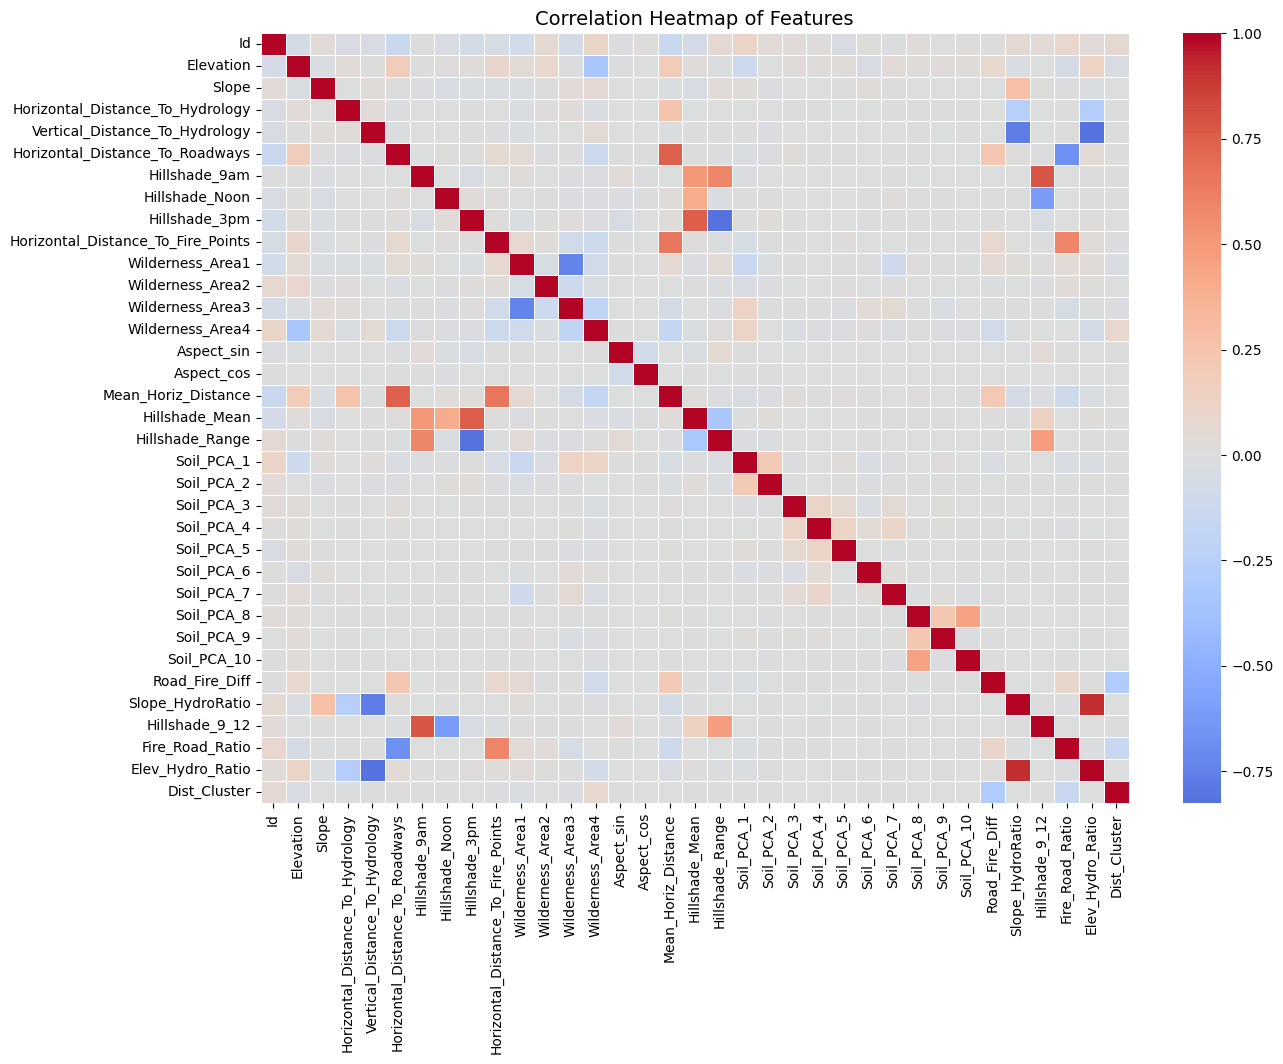

Highly correlated feature pairs (>0.9):
Slope_HydroRatio ↔ Elev_Hydro_Ratio: 0.918
Elev_Hydro_Ratio ↔ Slope_HydroRatio: 0.918

Skewness of features:
 Wilderness_Area4                      6.546293
Soil_PCA_8                            5.371582
Soil_PCA_4                            4.648021
Wilderness_Area2                      4.587674
Soil_PCA_3                            4.543007
Soil_PCA_1                            3.929052
Soil_PCA_2                            3.847083
Soil_PCA_10                           3.071921
Soil_PCA_7                            2.759475
Fire_Road_Ratio                       1.141670
Wilderness_Area1                      1.087254
Slope_HydroRatio                      0.942275
Elev_Hydro_Ratio                      0.758557
Horizontal_Distance_To_Fire_Points    0.546380
Horizontal_Distance_To_Roadways       0.494634
Mean_Horiz_Distance                   0.338963
Soil_PCA_6                            0.319686
Horizontal_Distance_To_Hydrology      0.284625
Soil

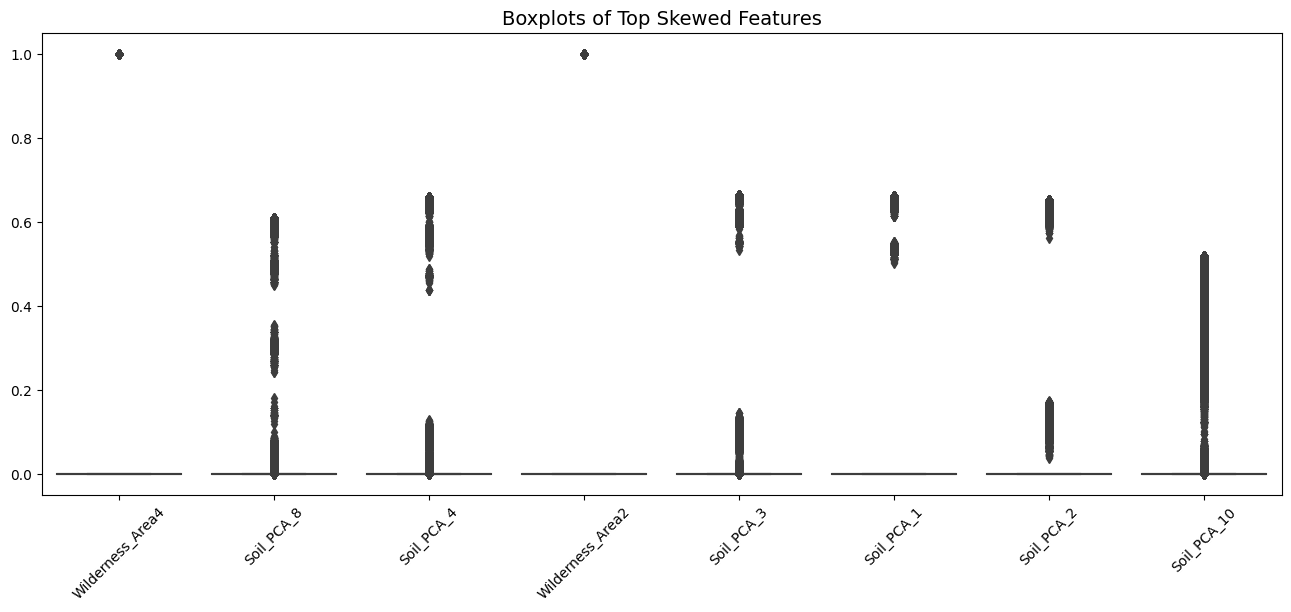

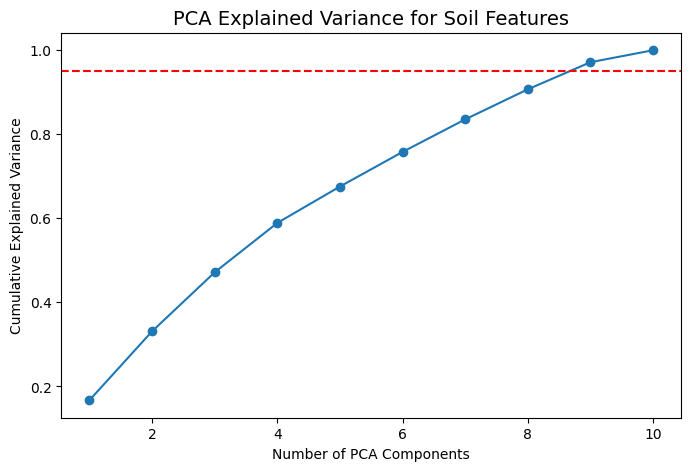

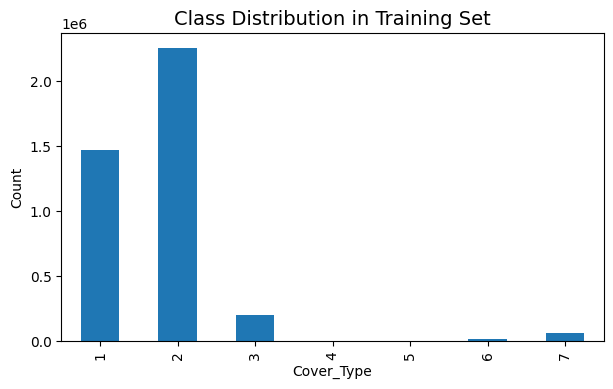

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Separate features and target
feature_cols = [c for c in train_transformed.columns if c != "Cover_Type"]

# === Correlation Heatmap (check redundancy) ===
plt.figure(figsize=(14,10))
corr = train_transformed[feature_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()

# Highly correlated pairs
high_corr = [(i, j, corr.loc[i,j]) for i in corr.columns for j in corr.columns
             if i != j and abs(corr.loc[i,j]) > 0.9]
print("Highly correlated feature pairs (>0.9):")
for i, j, val in high_corr:
    print(f"{i} ↔ {j}: {val:.3f}")

# === Outlier Check (boxplots for skewed features) ===
skewed_cols = train_transformed[feature_cols].skew().sort_values(ascending=False)
print("\nSkewness of features:\n", skewed_cols)

plt.figure(figsize=(16, 6))
sns.boxplot(data=train_transformed[skewed_cols.index[:8]])
plt.xticks(rotation=45)
plt.title("Boxplots of Top Skewed Features", fontsize=14)
plt.show()

# === PCA variance check for Soil features ===
soil_cols = [c for c in train_transformed.columns if c.startswith("Soil_PCA_")]
if soil_cols:
    pca = PCA().fit(train_transformed[soil_cols])
    explained = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(explained)+1), explained, marker="o")
    plt.axhline(0.95, color="red", linestyle="--")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Explained Variance for Soil Features", fontsize=14)
    plt.show()

# === Class distribution check ===
plt.figure(figsize=(7,4))
train_transformed["Cover_Type"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Distribution in Training Set", fontsize=14)
plt.xlabel("Cover_Type")
plt.ylabel("Count")
plt.show()


# Handle weight imbalance

In [16]:
y_train_np = y_train.values
y_val_np = y_val.values
classes = np.unique(y_train_np)

# Compute raw balanced class weights
raw_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_np)

# Log scaling to compress extremes
log_weights = np.log1p(raw_weights)

# Min-max scaling to [0.5, 2.0] range for stability
min_w, max_w = log_weights.min(), log_weights.max()
scaled_weights = 0.5 + (log_weights - min_w) * (1.5 / (max_w - min_w))

# Convert to PyTorch tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(scaled_weights, dtype=torch.float32).to(device)

print("Optimized Class Weights:", class_weights)

Optimized Class Weights: tensor([0.5241, 0.5000, 0.7545, 2.0000, 1.2948, 0.9575], device='cuda:0')


# Tensor conversion

In [17]:
# Features → float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

# Labels → long
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long)

# Dataset Class

In [18]:
class Cover_Type_Dataset(Dataset):
    def __init__(self, X, y, class_weights=None):
        self.X = X
        self.y = y
        self.class_weights = class_weights

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx].float()
        y = self.y[idx].long()
        if self.class_weights is not None:
            w = self.class_weights[y]
            return x, y, w
        else:
            return x, y

# Data Loaders

In [19]:
BATCH_SIZE = 1024

train_dataset = Cover_Type_Dataset(X_train_tensor, y_train_tensor, class_weights=class_weights)
val_dataset   = Cover_Type_Dataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Neural Network architecture 

In [20]:
class CoverTypeNN(nn.Module):
    def __init__(self, input_dim, num_classes, drop_rate=0.2, sd_prob=0.1):

        super().__init__()

        self.sd_prob = sd_prob  # stochastic depth

        # Layer definitions
        self.fc1 = nn.Linear(input_dim, 256)
        self.ln1 = nn.LayerNorm(256)
        self.dropout1 = nn.Dropout(drop_rate)

        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.dropout2 = nn.Dropout(drop_rate)

        self.fc3 = nn.Linear(128, 64)
        self.ln3 = nn.LayerNorm(64)
        self.dropout3 = nn.Dropout(drop_rate * 0.8)

        self.fc4 = nn.Linear(64, 32)
        self.ln4 = nn.LayerNorm(32)
        self.dropout4 = nn.Dropout(drop_rate * 0.8)

        # Residual projections
        self.res1 = nn.Linear(input_dim, 256)
        self.res2 = nn.Linear(256, 128)
        self.res3 = nn.Linear(128, 64)

        # Output
        self.out = nn.Linear(32, num_classes)
        self.act = nn.GELU()

    def stochastic_residual(self, x, identity):
        # Apply stochastic depth to residual
        if self.training and random.random() < self.sd_prob:
            return x  # skip residual
        return x + identity

    def forward(self, x):
        # Block 1
        identity = self.res1(x)
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.stochastic_residual(x, identity)
        x = self.act(x)

        # Block 2
        identity = self.res2(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.act(x)
        x = self.dropout2(x)
        x = self.stochastic_residual(x, identity)
        x = self.act(x)

        # Block 3
        identity = self.res3(x)
        x = self.fc3(x)
        x = self.ln3(x)
        x = self.act(x)
        x = self.dropout3(x)
        x = self.stochastic_residual(x, identity)
        x = self.act(x)

        # Block 4 (no residual)
        x = self.fc4(x)
        x = self.ln4(x)
        x = self.act(x)
        x = self.dropout4(x)

        # Output
        x = self.out(x)
        return x  # logits for CrossEntropyLoss

# Training

In [38]:
def train_model(model, train_loader, val_loader, 
                num_epochs=100, lr=0.002, weight_decay=1e-4,
                patience=6, min_lr=1e-6, max_grad_norm=5.0, factor=0.5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=factor, patience=3, min_lr=min_lr
    )
    scaler = GradScaler()

    best_val_loss = float('inf')
    counter = 0
    best_preds, best_labels = None, None

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss_sum, train_correct = 0.0, 0

        for X, y, w in train_loader:
            X, y, w = X.to(device), y.to(device), w.to(device)
            optimizer.zero_grad()

            with autocast(device_type="cuda"):
                outputs = model(X)
                loss = (criterion(outputs, y) * w).sum() / w.sum()

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            train_loss_sum += loss.item() * X.size(0)
            train_correct += (outputs.argmax(dim=1) == y).sum().item()

        avg_train_loss = train_loss_sum / len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss_sum, val_correct = 0.0, 0
        epoch_preds, epoch_labels = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                with autocast(device_type="cuda"):
                    outputs = model(X)
                    # Use uniform weight 1.0 for validation
                    loss = (criterion(outputs, y) * torch.ones_like(y, dtype=torch.float32, device=device)).mean()

                val_loss_sum += loss.item() * X.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                epoch_preds.extend(preds.cpu().numpy())
                epoch_labels.extend(y.cpu().numpy())

        avg_val_loss = val_loss_sum / len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_f1 = f1_score(epoch_labels, epoch_preds, average='macro')

        # Step scheduler with val loss
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch:03d} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-5:
            best_val_loss = avg_val_loss
            best_preds, best_labels = epoch_preds, epoch_labels
            torch.save(model.state_dict(), "best_model.pth")
            counter = 0
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")
            if counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(torch.load("best_model.pth"))
    return model, device, best_labels, best_preds

**Model training**

In [39]:
model = CoverTypeNN(input_dim=X_train_tensor.shape[1], num_classes=6)

trained_model, device, y_true, y_pred = train_model(
    model=model, train_loader=train_loader, val_loader=val_loader,)

Using device: cuda
Epoch 001 | LR: 0.002000 | Train Loss: 0.2093 | Train Acc: 0.9269 | Val Loss: 0.1471 | Val Acc: 0.9360 | Val F1: 0.6356
Epoch 002 | LR: 0.002000 | Train Loss: 0.1668 | Train Acc: 0.9377 | Val Loss: 0.1333 | Val Acc: 0.9412 | Val F1: 0.6487
Epoch 003 | LR: 0.002000 | Train Loss: 0.1585 | Train Acc: 0.9399 | Val Loss: 0.1283 | Val Acc: 0.9442 | Val F1: 0.6605
Epoch 004 | LR: 0.002000 | Train Loss: 0.1527 | Train Acc: 0.9418 | Val Loss: 0.1247 | Val Acc: 0.9455 | Val F1: 0.6877
Epoch 005 | LR: 0.002000 | Train Loss: 0.1462 | Train Acc: 0.9444 | Val Loss: 0.1168 | Val Acc: 0.9486 | Val F1: 0.6697
Epoch 006 | LR: 0.002000 | Train Loss: 0.1393 | Train Acc: 0.9466 | Val Loss: 0.1179 | Val Acc: 0.9477 | Val F1: 0.6875
Early stopping counter: 1/6
Epoch 007 | LR: 0.002000 | Train Loss: 0.1351 | Train Acc: 0.9480 | Val Loss: 0.1114 | Val Acc: 0.9512 | Val F1: 0.6802
Epoch 008 | LR: 0.002000 | Train Loss: 0.1327 | Train Acc: 0.9489 | Val Loss: 0.1088 | Val Acc: 0.9516 | Val F1: 

# Classification report

In [40]:
report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9615    0.9610    0.9612    293627
           1     0.9767    0.9656    0.9711    452418
           2     0.8467    0.9268    0.8849     39143
           3     0.4085    0.3867    0.3973        75
           4     0.5924    0.6718    0.6296      2285
           5     0.7476    0.8245    0.7842     12452

    accuracy                         0.9589    800000
   macro avg     0.7556    0.7894    0.7714    800000
weighted avg     0.9600    0.9589    0.9593    800000



# F1 scores (Macro / Weighted)

In [41]:
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"\nF1 (macro):    {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")


F1 (macro):    0.7714
F1 (weighted): 0.9593


# Confusion matrix

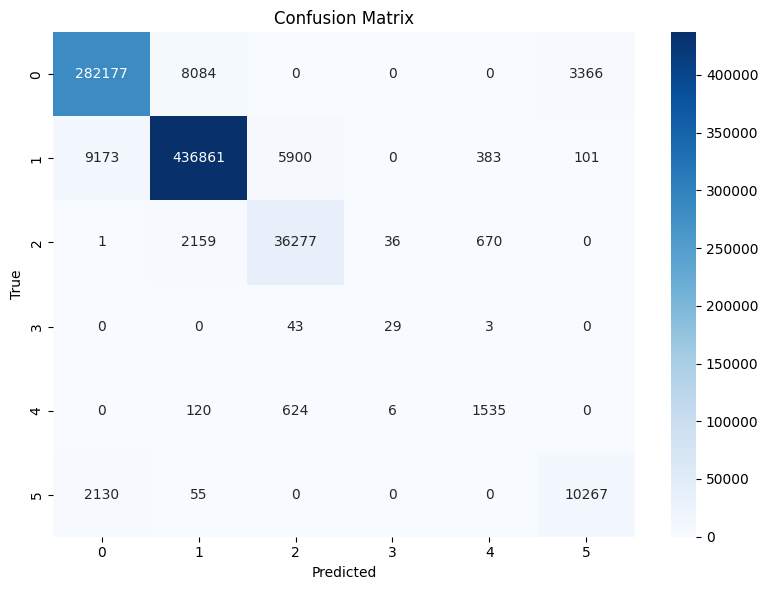

In [42]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(6), yticklabels=range(6))

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Testing

In [43]:
model.eval()

X_test_tensor = X_test_tensor.to(device)

BATCH_SIZE = 1024
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

all_preds = []

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch[0]
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())

# Concatenate batch predictions
all_preds = torch.cat(all_preds, dim=0)

# Map predictions back to original labels {0:1, 1:2, 2:3, 3:6, 4:7}
inv_label_map = {v: k for k, v in label_map.items()}
all_preds_original = np.vectorize(inv_label_map.get)(all_preds.numpy())

submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "Cover_Type": all_preds_original
})

submission_df.to_csv("submission.csv", index=False)
print("Submission saved successfully")

Submission saved successfully
